
# **VGG-16 vs LeNet-5**

## Description

The experimentation aims to assess the performance of two widely recognized architectures: [LeNet-5](https://ieeexplore.ieee.org/document/726791), a pioneering model in the field, and [VGG-16](https://arxiv.org/abs/1409.1556), renowned for its architectural depth. The evaluation will involve five models *M<sub>1A</sub>*, *M<sub>2A</sub>*,..., *M<sub>5A</sub>* each employing the LeNet-5 architecture, and an additional set of five models *M<sub>1B</sub>*, *M<sub>1B</sub>*,..., *M<sub>5B</sub>* corresponding to VGG-16. This dual approach enables us to comprehensively gauge the generalization capabilities of both architectures using diverse metrics.

![](https://i.postimg.cc/fyXk5fZ5/Le-Net-5-Architecture.png)
![](https://i.postimg.cc/c18Ks0YY/VGG-16-Architecture.png)

These models will undergo training using images focused on the genital papillae of Nile tilapia (Oreochromis niloticus), with the primary objective being the prediction of their sex through binary classification. This specialized focus on the tilapia's genital papillae ensures that the models are tailored to address the intricacies of sex prediction in this specific biological context. The utilization of distinct architectures and metrics will provide a robust foundation for comparative analysis, offering valuable insights into their respective strengths and weaknesses in the context of binary sex classification.

![](https://www.bigfish.mx/__export/1494447198016/sites/debate/img/2017/05/10/tilapia.jpg_1902800913.jpg)
![](https://i.postimg.cc/BZLw3W8P/Dataset.png)


This meticulous analysis reveals how the VGG-16 architecture outperforms LeNet-5 on the specific task of binary sex classification in tilapia, highlighting the importance of choosing the right architecture for specific biological problems. The results present a detailed view of performance differences, enabling informed decision making in future binary classification projects in similar biological contexts.

![](https://i.postimg.cc/W46nY0pN/Graph-VGG-16-vs-Le-Net-5.png)
![](https://i.postimg.cc/SKpdGgh1/Results-VGG-Le-Net.png)



# **Importing the Libraries**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import model_from_json
from os.path import isfile, join
from os import listdir

import seaborn as sns
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.applications import VGG16
from keras.layers import GlobalMaxPooling2D, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam


# **Functions**

In [ ]:
def loadModel(nameModel):
    json_file = open( nameModel + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    cnn = model_from_json(loaded_model_json)
    cnn.load_weights(nameModel + ".h5")
    print("Loaded model from disk")
    return cnn

In [ ]:
def prediction(model, pathBatch, classValue, classes):
    class_test    = [f for f in listdir(pathBatch) if isfile(join(pathBatch, f))]
    roundedValues = np.zeros(len(class_test))
    realValues    = np.zeros(len(class_test))
    wrongPaths    = []
    wrongErrors   = []


    for i in range(len(class_test)):
        if not (".DS_Store" in class_test[i]):
            path = pathBatch + "/" + class_test[i]
            test_image = tf.keras.preprocessing.image.load_img(path, target_size=(64,64))
            test_image = tf.keras.preprocessing.image.img_to_array(test_image)
            test_image = np.expand_dims(test_image, axis=0)
            result     = model.predict(test_image/255.0, verbose=0)
            realValues[i]  = result
            if result[0][0] > 0.5:
                roundedValues[i] = 1
            else: 
                roundedValues[i] = 0
            error = abs(classes.get(classValue) - result)
            if(error > 0.5):
                wrongPaths.append(path)
                wrongErrors.append(error)

    
    if(classes.get(classValue)):
        accuracy = np.mean(roundedValues)
    else:
        accuracy = np.mean(np.where(roundedValues == 0, 1, 0))

    return accuracy, realValues, roundedValues, wrongPaths, wrongErrors

In [ ]:
def cargar_y_evaluar_modelos(test_set):
    archivos_h5 = [archivo.rstrip('.h5') for archivo in os.listdir() if archivo.endswith('.h5')]
    #archivos_h5 = sorted(archivos_h5, key=lambda x: int(x.split('-')[0]))
    
    for i,modelo_archivo in enumerate(archivos_h5):
        print("Resultados del modelo " + str(i+1))
        print(f"Modelo del archivo: {modelo_archivo}")
             
        modelo = loadModel(modelo_archivo)
        print(list(test_set.class_indices.keys()))
        classes = list(test_set.class_indices.keys())

        
        accuracyHembras, realValuesHembras, roundedValuesHembras, wrongPathsHembras, wrongErrorsHembras = prediction(model=modelo, pathBatch="../dataset/test_set/hembras", classValue=classes[0], classes=test_set.class_indices)      
        accuracyMachos, realValuesMachos, roundedValuesMachos, wrongPathsMachos, wrongErrorsMachos = prediction(model=modelo, pathBatch="../dataset/test_set/machos", classValue=classes[1], classes=test_set.class_indices)
        
        print(f'Modelo con precisión en test con hembras: {accuracyHembras}')
        print(f'Modelo con precisión en test con machos: {accuracyMachos}')
        
        accuracy_general = (accuracyHembras + accuracyMachos) / 2
        print(f'Accuracy general del modelo: {accuracy_general}')
        
        pred = np.concatenate([roundedValuesHembras, roundedValuesMachos])
        result = confusion_matrix(test_set.classes, pred)
        
        sns.heatmap(result, annot=True, cmap='Blues', fmt='g')
        plt.show()  

        axisXHembras = np.linspace(0,(realValuesHembras.shape[0]-1),realValuesHembras.shape[0])
        axisXMachos  = np.linspace(0,(realValuesMachos.shape[0]-1),realValuesMachos.shape[0])

        plt.scatter(axisXHembras, realValuesHembras, c="#CD5C5C")
        plt.scatter(axisXMachos, realValuesMachos, c="#2E86C1")
        plt.axhline(y=0.5, color='green', linestyle='-')
        plt.show()
        
        print(classification_report(test_set.classes, pred))
        print("\n")


# **Part 1 - Data Augmentation**


## **Preprocessing the Training set**

In [ ]:
#Para evitar el overfitting, se deben realizar diversos cambios con el conjunto de datos, para ello se aplica
#la estandarización de los datos, rango de corte, rango de zoom y rotaciones horizontales.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30
)

training_set = train_datagen.flow_from_directory(
    #Directorio del conjunto de entrenamiento.
    '../dataset/training_set',
    #Tamaño final de las imágenes parala entrada del modelo (uniformidad de tamaños)
    target_size=(64, 64),
    #El tamaño de las imágenes que queremos tener en cada lote.
    batch_size=32,
    shuffle=True,
    class_mode='binary')

Found 3110 images belonging to 2 classes.



## **Preprocessing the Test set**

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    '../dataset/test_set',
    target_size=(64,64),
    batch_size=32,
    shuffle=True,
    class_mode='binary',)

Found 240 images belonging to 2 classes.


## **Visualizing Data Augmentation**

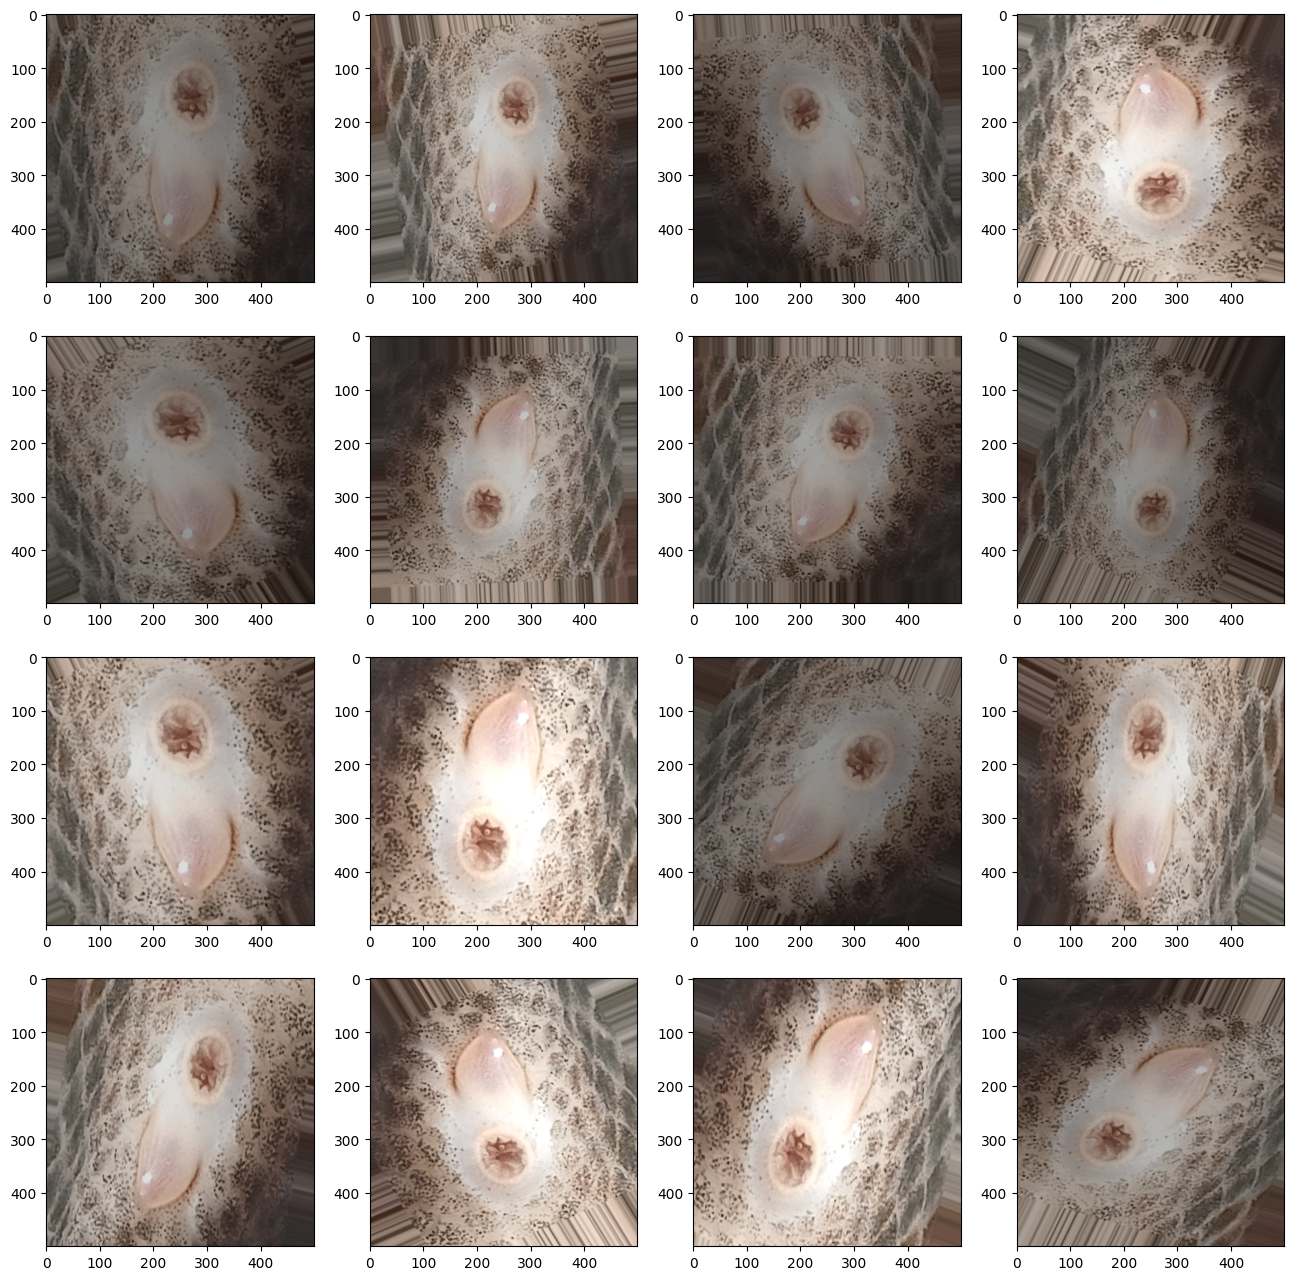

In [ ]:
image_path = '../dataset/training_set/machos/IMG_20220830_093925287.jpg'

img = tf.keras.preprocessing.image.load_img(image_path, target_size= (500,500))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
#Uses ImageDataGenerator to flip the images
datagen = ImageDataGenerator(    
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.1],
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30                   
                            )
#Creates our batch of one image
pic = datagen.flow(img_tensor, batch_size =1)
plt.figure(figsize=(16, 16))
#Plots our figures
for i in range(1,17):
   plt.subplot(4, 4, i)
   batch = pic.next()
   image_ = batch[0].astype('uint8')
   plt.imshow(image_)
plt.show()


# **Part 2 - VGG-16 vs LeNet-5**


## **Create LeNet-5 model**

In [ ]:
def create_LeNET5():
    lenet5 = tf.keras.models.Sequential()
    lenet5.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
    lenet5.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    lenet5.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    lenet5.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    lenet5.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    lenet5.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    lenet5.add(tf.keras.layers.Flatten())

    adam = Adam()

    lenet5.add(tf.keras.layers.Dense(units=512, activation='relu'))
    lenet5.add(tf.keras.layers.Dropout(0.41))
    lenet5.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    lenet5.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return lenet5


## **Create VGG-16 model**

In [ ]:
def create_VGG16(input_shape=(64, 64, 3)):
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
    for layer in pre_trained_model.layers[:15]:
        layer.trainable = False

    for layer in pre_trained_model.layers[15:]:
        layer.trainable = True
    
    last_layer = pre_trained_model.get_layer('block5_pool')
    last_output = last_layer.output
    
    x = GlobalMaxPooling2D()(last_output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.41)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(pre_trained_model.input, x)

    adam = Adam()

    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    
    return model


## **VGG-16 training and results**

In [ ]:
epochs = 5
historiesVGG16 = []

for epoch in np.arange(epochs):
    vgg16 = create_VGG16()
    history = vgg16.fit(x=training_set, validation_data=test_set, epochs=100)
    historiesVGG16.append(history)
    name = vgg16.evaluate(test_set)[1]
    model_json = vgg16.to_json()
    with open(str(epoch) + str(name) + ".json", "w") as json_file:
        json_file.write(model_json)
    vgg16.save_weights(str(epoch) + str(name) + ".h5")
    print("Saved model to disk")    

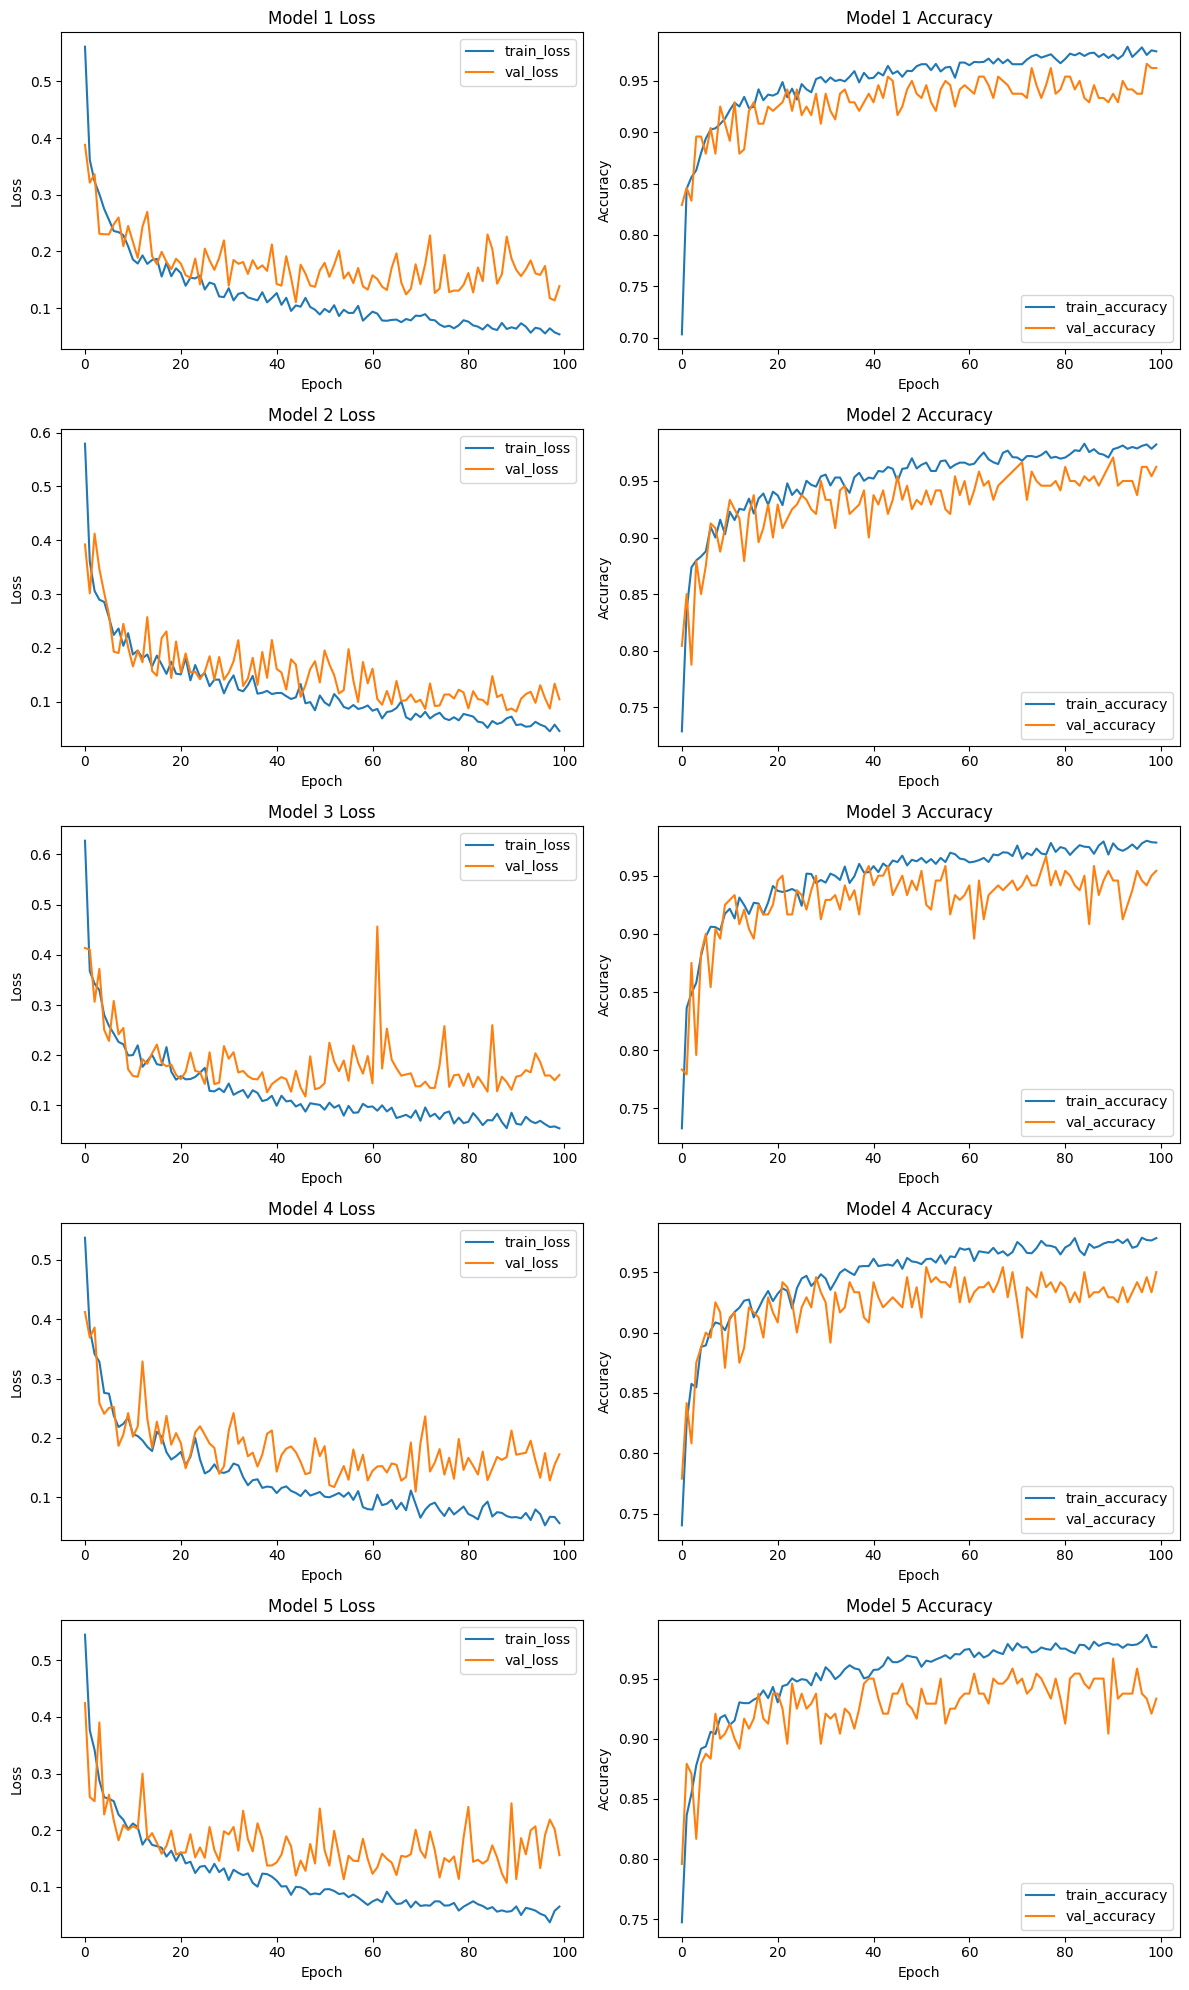

In [ ]:
fig, axes = plt.subplots(nrows=len(historiesVGG16), ncols=2, figsize=(12, len(historiesVGG16) * 4))

# Iterar a través de las historias de los modelos
for i, history in enumerate(historiesVGG16):
    # Subgráfica de precisión
    axes[i, 1].plot(history.history['accuracy'], label='train_accuracy')
    axes[i, 1].plot(history.history['val_accuracy'], label='val_accuracy')
    axes[i, 1].set_title(f'Model {i + 1} Accuracy')
    axes[i, 1].set_xlabel('Epoch')
    axes[i, 1].set_ylabel('Accuracy')
    axes[i, 1].legend()


    # Subgráfica de pérdida
    axes[i, 0].plot(history.history['loss'], label='train_loss')
    axes[i, 0].plot(history.history['val_loss'], label='val_loss')
    axes[i, 0].set_title(f'Model {i + 1} Loss')
    axes[i, 0].set_xlabel('Epoch')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].legend()

# Ajustar el diseño de las subgráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()


Resultados del modelo 1
Modelo del archivo: 20.9541666507720947
Loaded model from disk
['hembras', 'machos']
Modelo con precisión en test con hembras: 0.9666666666666667
Modelo con precisión en test con machos: 0.9416666666666667
Accuracy general del modelo: 0.9541666666666666


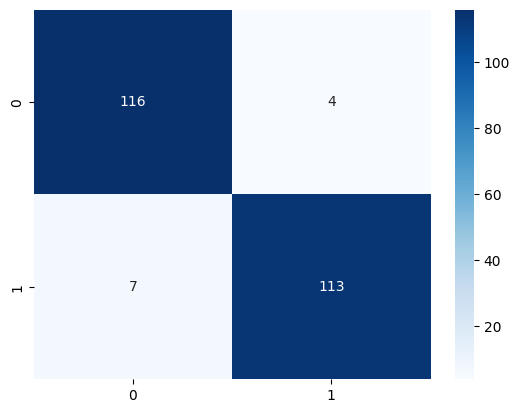

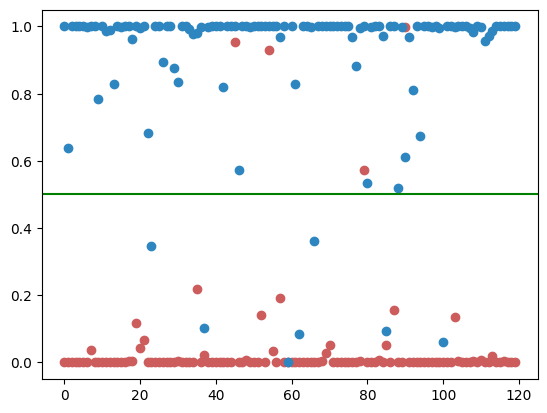

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       120
           1       0.97      0.94      0.95       120

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



Resultados del modelo 2
Modelo del archivo: 30.949999988079071
Loaded model from disk
['hembras', 'machos']
Modelo con precisión en test con hembras: 0.9
Modelo con precisión en test con machos: 1.0
Accuracy general del modelo: 0.95


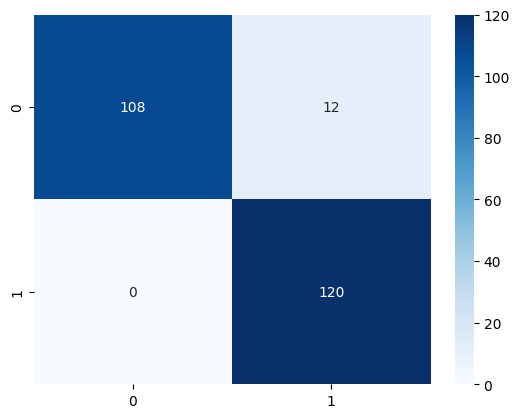

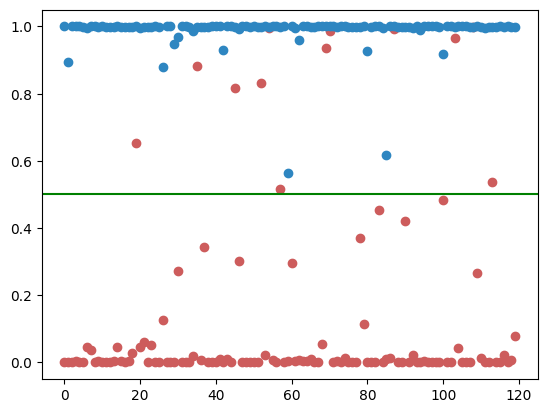

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       120
           1       0.91      1.00      0.95       120

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



Resultados del modelo 3
Modelo del archivo: 10.9624999761581421
Loaded model from disk
['hembras', 'machos']
Modelo con precisión en test con hembras: 0.9583333333333334
Modelo con precisión en test con machos: 0.9666666666666667
Accuracy general del modelo: 0.9625


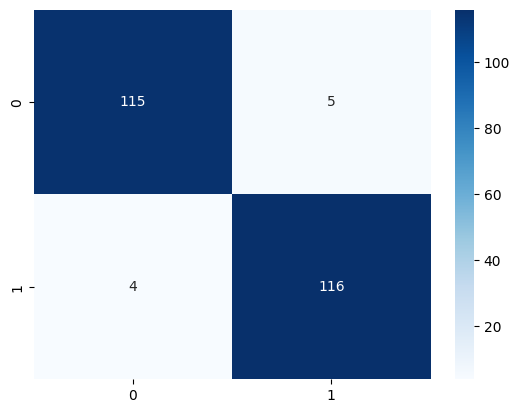

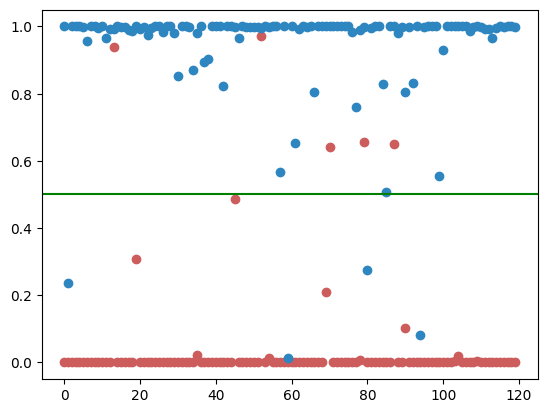

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       120
           1       0.96      0.97      0.96       120

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



Resultados del modelo 4
Modelo del archivo: 40.9333333373069763
Loaded model from disk
['hembras', 'machos']
Modelo con precisión en test con hembras: 0.9583333333333334
Modelo con precisión en test con machos: 0.9083333333333333
Accuracy general del modelo: 0.9333333333333333


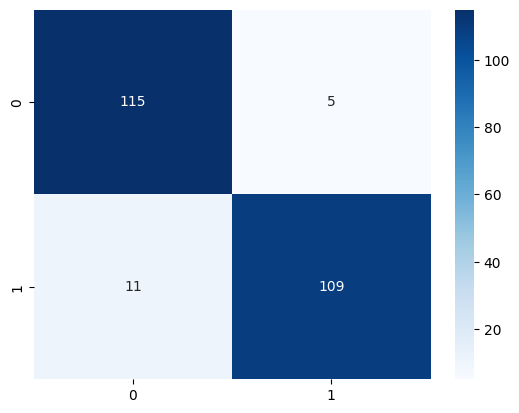

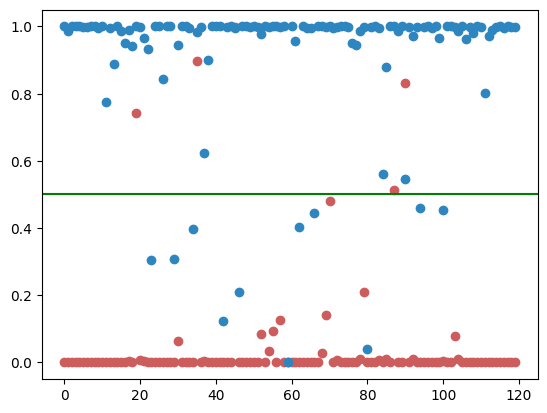

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       120
           1       0.96      0.91      0.93       120

    accuracy                           0.93       240
   macro avg       0.93      0.93      0.93       240
weighted avg       0.93      0.93      0.93       240



Resultados del modelo 5
Modelo del archivo: 00.9624999761581421
Loaded model from disk
['hembras', 'machos']
Modelo con precisión en test con hembras: 0.95
Modelo con precisión en test con machos: 0.975
Accuracy general del modelo: 0.9624999999999999


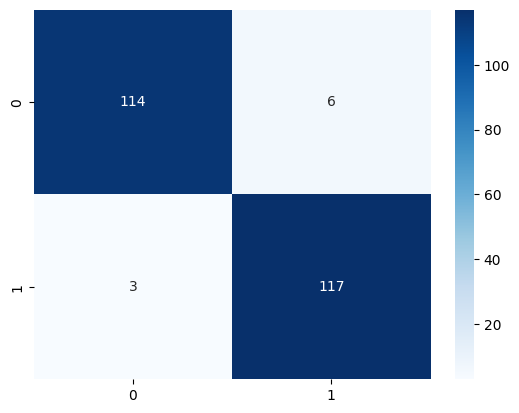

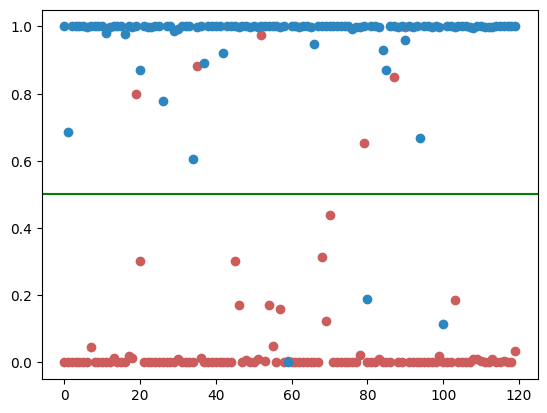

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       120
           1       0.95      0.97      0.96       120

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240





In [ ]:
cargar_y_evaluar_modelos(test_set)

In [ ]:
output_dir = 'metricas_vgg16/'

os.makedirs(output_dir, exist_ok=True)

for i, history in enumerate(historiesVGG16):
    model_loss = history.history['loss']  
    val_loss = history.history['val_loss']  
    model_accuracy = history.history['accuracy']  
    val_accuracy = history.history['val_accuracy']  
    
    csv_filename = f'{output_dir}model{i+1}_metrics.csv'
    
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Val_Loss', 'Train_Accuracy', 'Val_Accuracy'])
        for epoch in range(len(model_loss)):
            writer.writerow([epoch+1, model_loss[epoch], val_loss[epoch], model_accuracy[epoch], val_accuracy[epoch]])

    print(f"Se ha guardado el archivo CSV para el modelo {i+1} en {csv_filename}")

Se ha guardado el archivo CSV para el fold 1 en metricas_vgg16/fold_1_metrics.csv
Se ha guardado el archivo CSV para el fold 2 en metricas_vgg16/fold_2_metrics.csv
Se ha guardado el archivo CSV para el fold 3 en metricas_vgg16/fold_3_metrics.csv
Se ha guardado el archivo CSV para el fold 4 en metricas_vgg16/fold_4_metrics.csv
Se ha guardado el archivo CSV para el fold 5 en metricas_vgg16/fold_5_metrics.csv



## **LeNet-5 training and results**

In [ ]:
epochs = 5
historiesLeNet5 = []

for epoch in np.arange(epochs):
    lenet5 = create_LeNET5()
    history = lenet5.fit(x=training_set, validation_data=test_set, epochs=100)
    historiesLeNet5.append(history)
    name = lenet5.evaluate(test_set)[1]
    model_json = lenet5.to_json()
    with open(str(epoch) + str(name) + ".json", "w") as json_file:
        json_file.write(model_json)
    lenet5.save_weights(str(epoch) + str(name) + ".h5")
    print("Saved model to disk")  

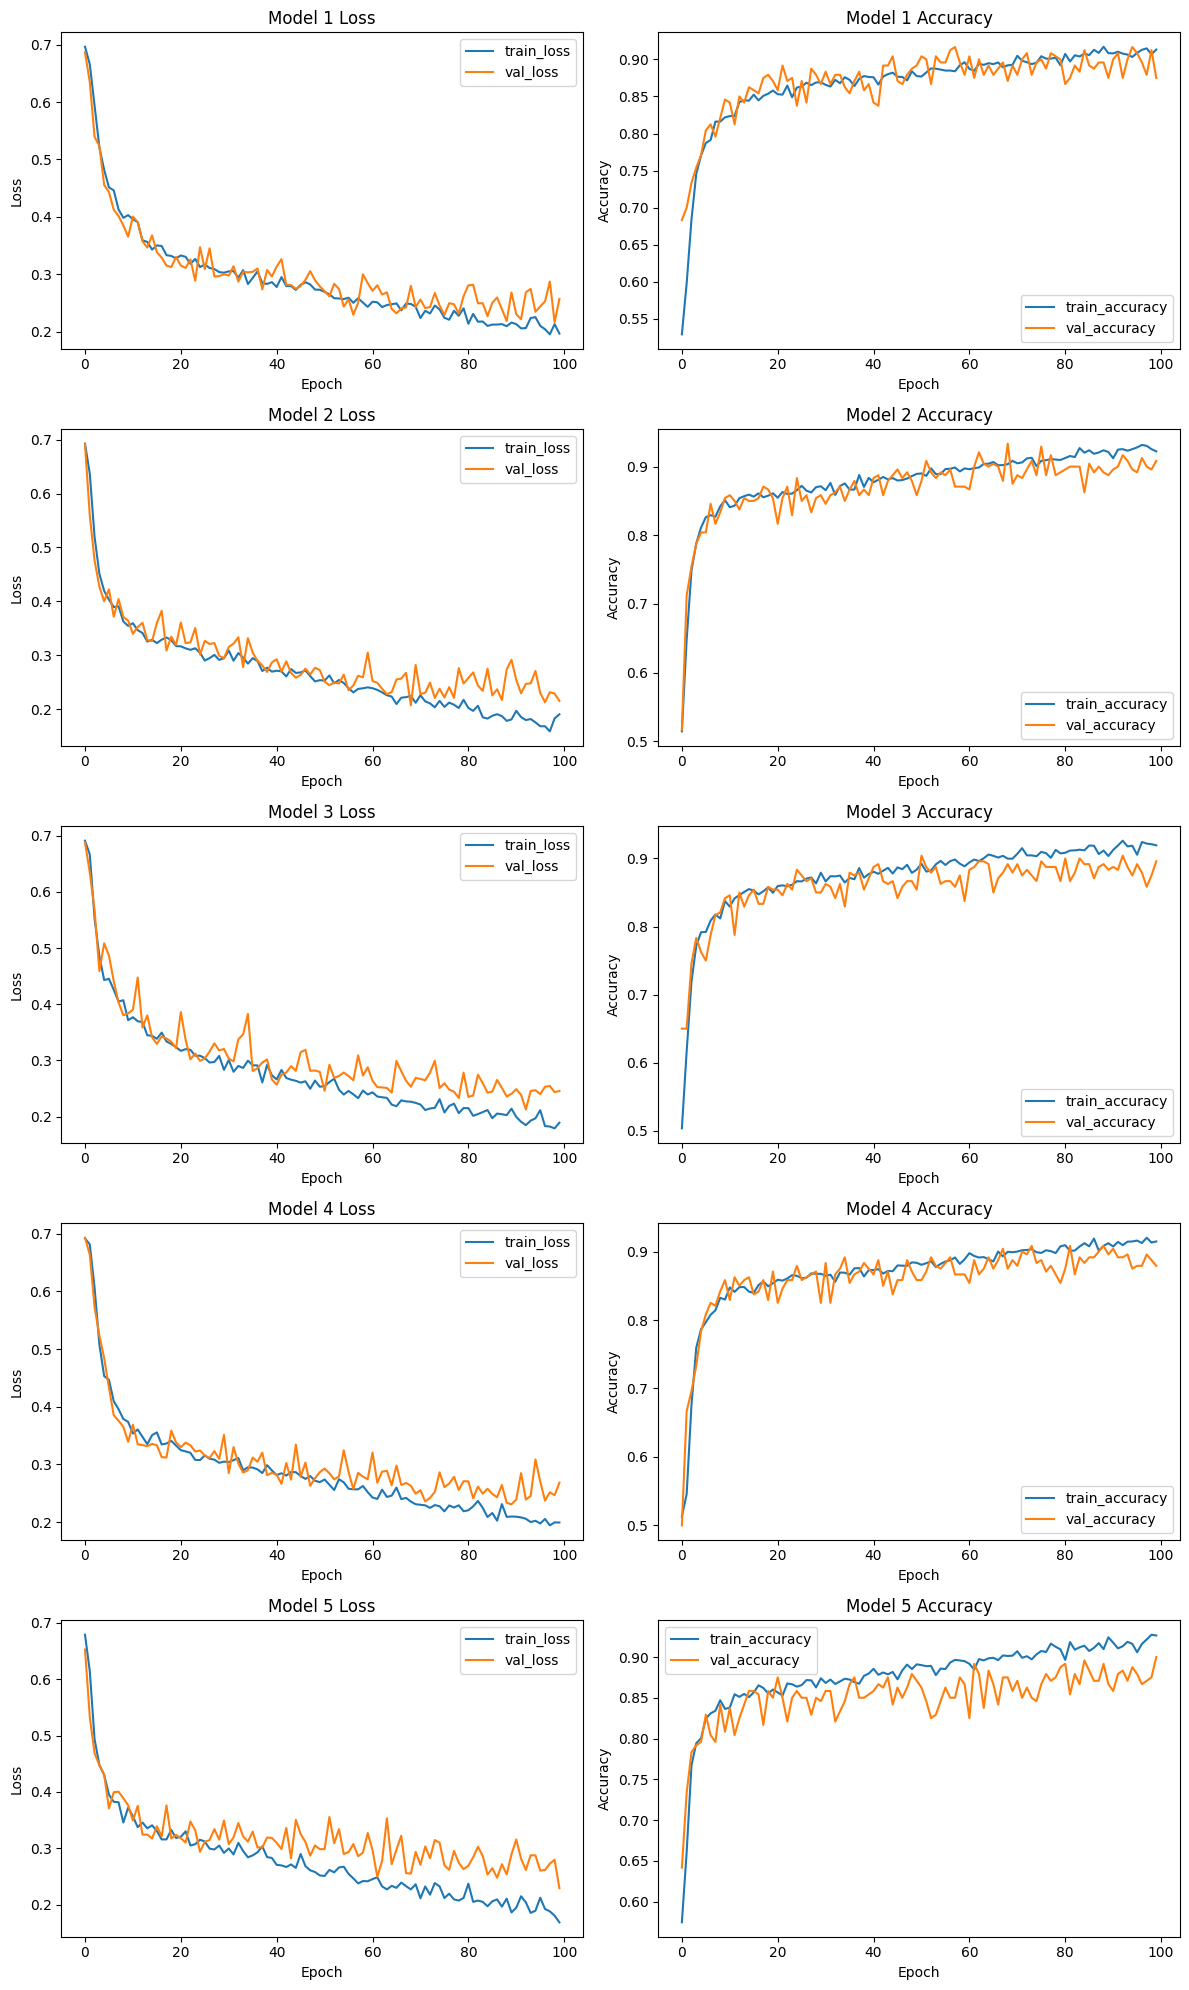

In [ ]:
fig, axes = plt.subplots(nrows=len(historiesLeNet5), ncols=2, figsize=(12, len(historiesLeNet5) * 4))

# Iterar a través de las historias de los modelos
for i, history in enumerate(historiesLeNet5):
    # Subgráfica de precisión
    axes[i, 1].plot(history.history['accuracy'], label='train_accuracy')
    axes[i, 1].plot(history.history['val_accuracy'], label='val_accuracy')
    axes[i, 1].set_title(f'Model {i + 1} Accuracy')
    axes[i, 1].set_xlabel('Epoch')
    axes[i, 1].set_ylabel('Accuracy')
    axes[i, 1].legend()


    # Subgráfica de pérdida
    axes[i, 0].plot(history.history['loss'], label='train_loss')
    axes[i, 0].plot(history.history['val_loss'], label='val_loss')
    axes[i, 0].set_title(f'Model {i + 1} Loss')
    axes[i, 0].set_xlabel('Epoch')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].legend()

# Ajustar el diseño de las subgráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()


Resultados del modelo 1
Modelo del archivo: 20.8958333134651184
Loaded model from disk
['hembras', 'machos']
Modelo con precisión en test con hembras: 0.8666666666666667
Modelo con precisión en test con machos: 0.925
Accuracy general del modelo: 0.8958333333333334


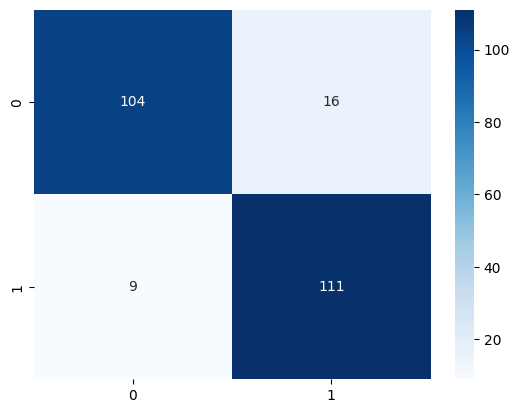

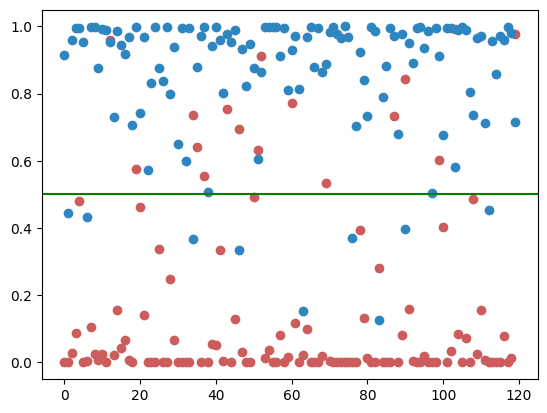

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       120
           1       0.87      0.93      0.90       120

    accuracy                           0.90       240
   macro avg       0.90      0.90      0.90       240
weighted avg       0.90      0.90      0.90       240



Resultados del modelo 2
Modelo del archivo: 40.8999999761581421
Loaded model from disk
['hembras', 'machos']
Modelo con precisión en test con hembras: 0.9
Modelo con precisión en test con machos: 0.9
Accuracy general del modelo: 0.9


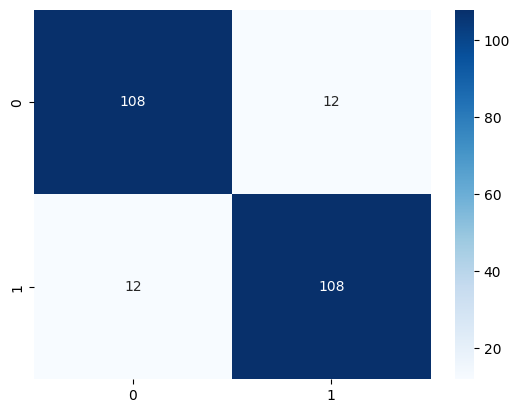

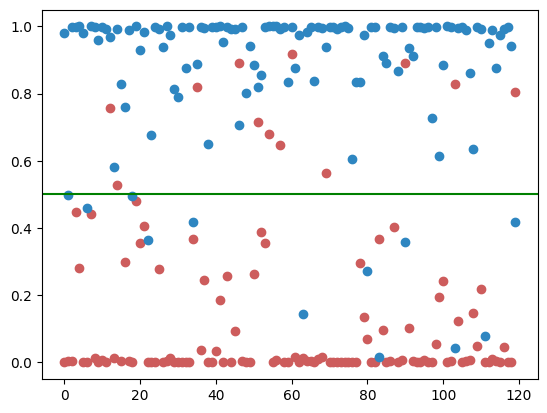

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       120
           1       0.90      0.90      0.90       120

    accuracy                           0.90       240
   macro avg       0.90      0.90      0.90       240
weighted avg       0.90      0.90      0.90       240



Resultados del modelo 3
Modelo del archivo: 30.8791666626930237
Loaded model from disk
['hembras', 'machos']
Modelo con precisión en test con hembras: 0.875
Modelo con precisión en test con machos: 0.8833333333333333
Accuracy general del modelo: 0.8791666666666667


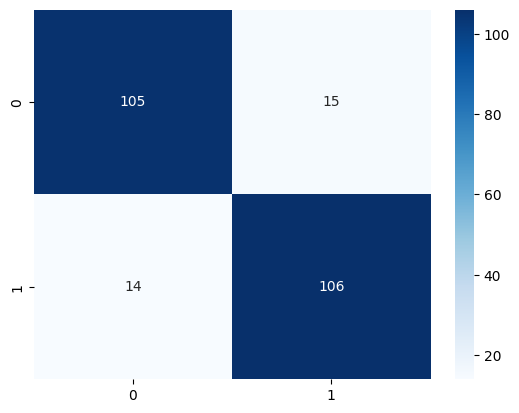

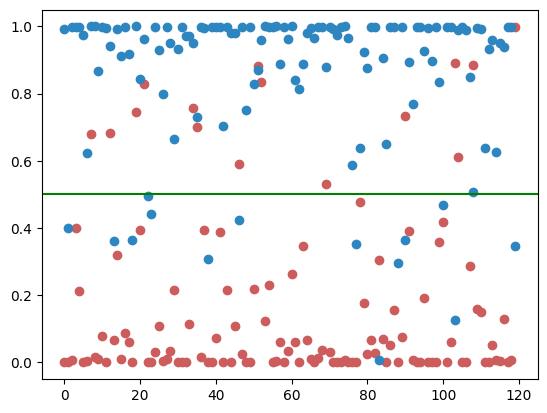

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       120
           1       0.88      0.88      0.88       120

    accuracy                           0.88       240
   macro avg       0.88      0.88      0.88       240
weighted avg       0.88      0.88      0.88       240



Resultados del modelo 4
Modelo del archivo: 10.9083333611488342
Loaded model from disk
['hembras', 'machos']
Modelo con precisión en test con hembras: 0.8916666666666667
Modelo con precisión en test con machos: 0.925
Accuracy general del modelo: 0.9083333333333334


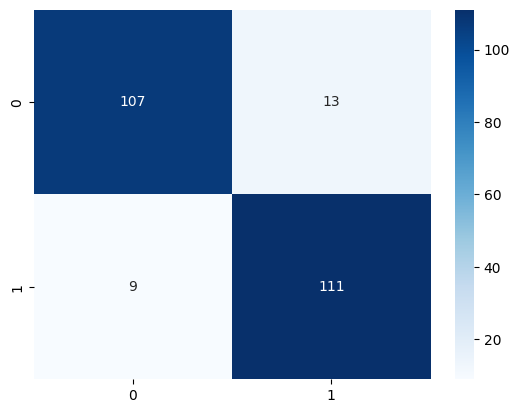

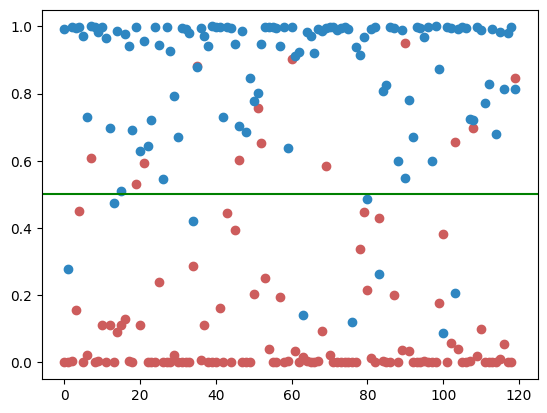

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       120
           1       0.90      0.93      0.91       120

    accuracy                           0.91       240
   macro avg       0.91      0.91      0.91       240
weighted avg       0.91      0.91      0.91       240



Resultados del modelo 5
Modelo del archivo: 00.8750
Loaded model from disk
['hembras', 'machos']
Modelo con precisión en test con hembras: 0.8166666666666667
Modelo con precisión en test con machos: 0.9333333333333333
Accuracy general del modelo: 0.875


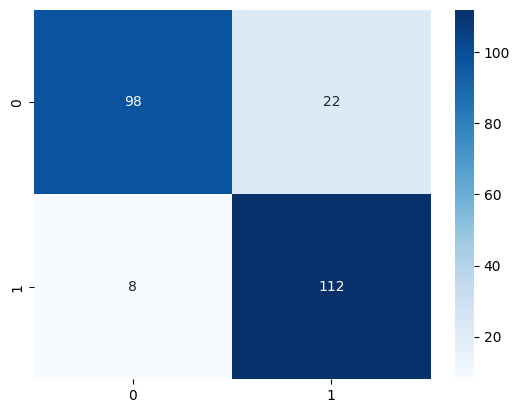

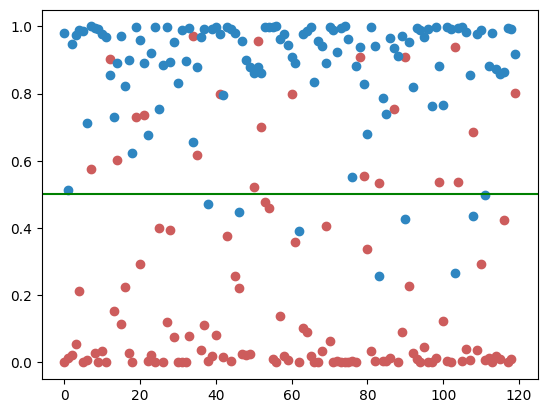

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       120
           1       0.84      0.93      0.88       120

    accuracy                           0.88       240
   macro avg       0.88      0.88      0.87       240
weighted avg       0.88      0.88      0.87       240





In [ ]:
cargar_y_evaluar_modelos(test_set)

In [ ]:
import csv

output_dir = 'metricas_lenet5/'

import os
os.makedirs(output_dir, exist_ok=True)

for i, history in enumerate(historiesLeNet5):
    model_loss = history.history['loss']  
    val_loss = history.history['val_loss']  
    model_accuracy = history.history['accuracy']  
    val_accuracy = history.history['val_accuracy']  
    
    csv_filename = f'{output_dir}fold_{i+1}_metrics.csv'
    
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Val_Loss', 'Train_Accuracy', 'Val_Accuracy'])
        for epoch in range(len(model_loss)):
            writer.writerow([epoch+1, model_loss[epoch], val_loss[epoch], model_accuracy[epoch], val_accuracy[epoch]])

    print(f"Se ha guardado el archivo CSV para el fold {i+1} en {csv_filename}")

Se ha guardado el archivo CSV para el fold 1 en metricas_lenet5/fold_1_metrics.csv
Se ha guardado el archivo CSV para el fold 2 en metricas_lenet5/fold_2_metrics.csv
Se ha guardado el archivo CSV para el fold 3 en metricas_lenet5/fold_3_metrics.csv
Se ha guardado el archivo CSV para el fold 4 en metricas_lenet5/fold_4_metrics.csv
Se ha guardado el archivo CSV para el fold 5 en metricas_lenet5/fold_5_metrics.csv



## **Comparing VGG-16 and LeNet-5 results**

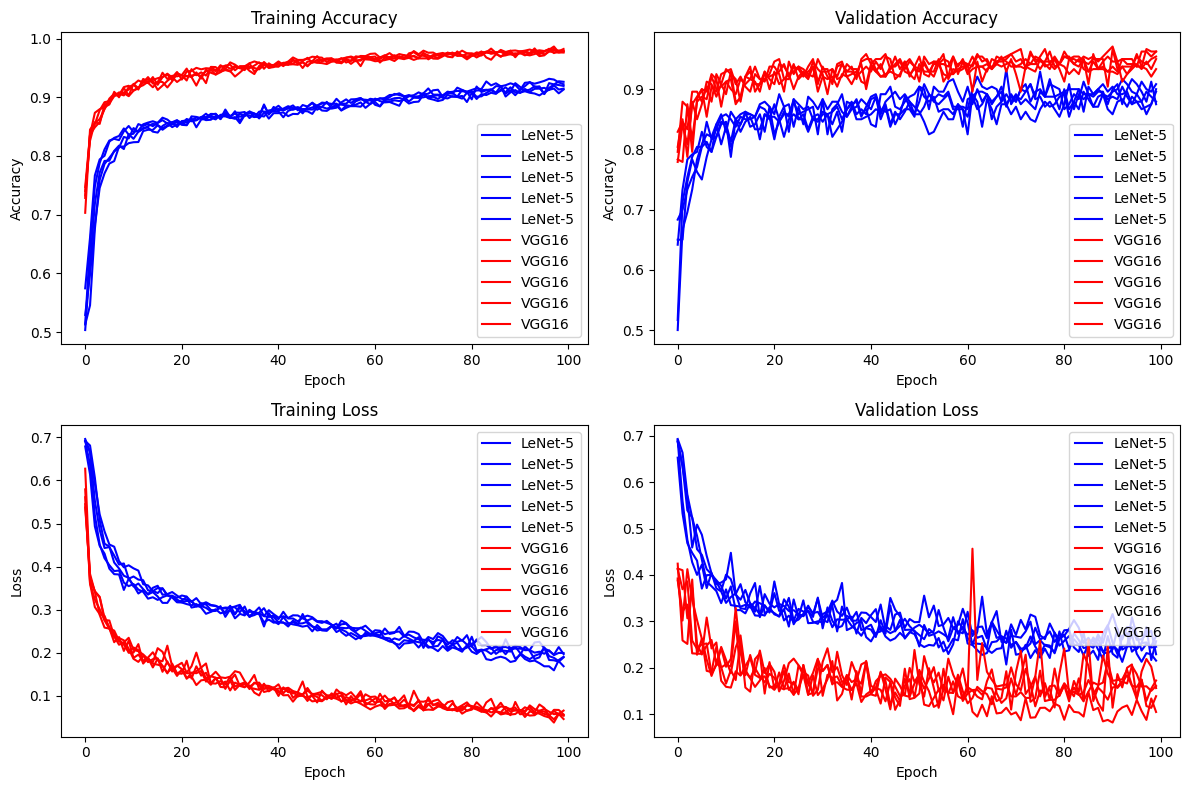

In [ ]:
import matplotlib.pyplot as plt

all_train_accuracy = []
all_val_accuracy = []
all_train_loss = []
all_val_loss = []

for i, history in enumerate(historiesLeNet5):
    all_train_accuracy.append(history.history['accuracy'])
    all_val_accuracy.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

for i, history in enumerate(historiesVGG16):
    all_train_accuracy.append(history.history['accuracy'])
    all_val_accuracy.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for train_acc in all_train_accuracy[:len(historiesLeNet5)]:
    axes[0, 0].plot(train_acc, label='LeNet-5', color='blue')
for train_acc in all_train_accuracy[len(historiesLeNet5):]:
    axes[0, 0].plot(train_acc, label='VGG16', color='red')
axes[0, 0].set_title('Training Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

for val_acc in all_val_accuracy[:len(historiesLeNet5)]:
    axes[0, 1].plot(val_acc, label='LeNet-5', color='blue')
for val_acc in all_val_accuracy[len(historiesLeNet5):]:
    axes[0, 1].plot(val_acc, label='VGG16', color='red')
axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

for train_loss in all_train_loss[:len(historiesLeNet5)]:
    axes[1, 0].plot(train_loss, label='LeNet-5', color='blue')
for train_loss in all_train_loss[len(historiesLeNet5):]:
    axes[1, 0].plot(train_loss, label='VGG16', color='red')
axes[1, 0].set_title('Training Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

for val_loss in all_val_loss[:len(historiesLeNet5)]:
    axes[1, 1].plot(val_loss, label='LeNet-5', color='blue')
for val_loss in all_val_loss[len(historiesLeNet5):]:
    axes[1, 1].plot(val_loss, label='VGG16', color='red')
axes[1, 1].set_title('Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

plt.tight_layout()

plt.show()